### Pretrained RESNET Encoder with UNET Decoder
Using pre-trained weights to improve training speed.

Here, we use pre-trained RESNET weights to start the model.  We will only import the top of the network and add new layers at the bottom to reflect our desired output.

The strategy is to used the pretrained RESNET as the encoder and then train a UNET decoder.  We will use RESNET as the base and add the UNET decoder layers, then freeze the RESNET encoder and train the model.



![title](../VGG_with_Residual_Blocks.png)

Although this may be a little difficult to read, it shows an important progression.  Resnet is an evolution of VGG.  The first model on the left shows a 19-layer VGG model.  The second model shows a deeper VGG 34-layer model.

In general, as a network gets deeper, it has a greater capacity to identify more classes but will concurrently suffer an overtraing that will essentially create a network that performs identically to its shallower counterpart.  This wastes time building and training the network and creates slower inference times.  In this scenario, the network only learned as much as the shallow network offering no benefit. 

In order to resolve this, a "residual" pattern is added to the model in order to ensure that previous layer information is propagated to subsequent layers.  This is represented by the arrows between blocks in the model on the right.

This architecture is referred to as a Residual Network, or more commoly referred to as ResNet.


https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

### Setup local Variables

In [1]:
import os, sys
data_dir    = '../../../data/FashionDataSet/'
train_dir   = os.path.join(data_dir, 'train')
images_file = os.path.join(data_dir, 'train.csv' )
cat_file    = os.path.join(data_dir, 'label_descriptions.json' )
os.path.isdir(data_dir), os.path.isdir(train_dir), os.path.isfile(images_file), os.path.isfile(images_file)

(True, True, True, True)

In [2]:
import os
# fix libiomp5.dylib error for mac
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# OPTIONAL SETTING
# Here we override the keras backend env variable to use plaidml
# plaidml can make use of AMD GPUs 
# This assignment needs to be added before loading keras libraries

# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# to install plaidML, activate appropriate environment and then:
#   pip install -U plaidml-keras
#   plaidml-setup

In [3]:

import datetime, os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import seaborn as sns
import tensorflow as tf
import pickle
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import skimage
import random
# from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from mrcnn.visualize import display_images

%matplotlib inline 

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [8]:
# Keras imports
if os.environ.get("KERAS_BACKEND") == "plaidml.keras.backend":
    print("Loading Plaid libraries for Keras.")
    import keras
    
    from keras.models import Model, load_model, model_from_json
    from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from keras.layers.core import Lambda, RepeatVector, Reshape
    from keras.layers.convolutional import Conv2D, Conv2DTranspose
    from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from keras.layers.merge import concatenate, add
    from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from keras.optimizers import Adam, SGD
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.utils import to_categorical, Sequence
    from keras.layers import UpSampling2D
    from keras.preprocessing import image
    from keras.applications.resnet_v2 import ResNet152V2, ResNet50V2 # https://keras.io/applications/
    from keras.applications.resnet import ResNet50

else:
    print("Loading Tensorflow libraries for Keras.")
    import tensorflow as tf

    from tensorflow.python.keras.models import Model, load_model, model_from_json
    from tensorflow.python.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
    from tensorflow.python.keras.layers.core import Lambda, RepeatVector, Reshape
    from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
    from tensorflow.python.keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
    from tensorflow.python.keras.layers.merge import concatenate, add
    from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
    from tensorflow.python.keras.optimizers import Adam, SGD
    from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from tensorflow.python.keras.utils import to_categorical, Sequence
    from tensorflow.python.keras.layers import UpSampling2D
    from tensorflow.python.keras.preprocessing import image
    from tensorflow.python.keras.applications.resnet_v2 import ResNet152V2, ResNet50V2# https://keras.io/applications/
    from tensorflow.python.keras.applications.resnet import ResNet50
    

Loading Tensorflow libraries for Keras.


### Define FashionDataset Object

In [9]:
class FashionDataset(utils.Dataset):
    
    @staticmethod
    def load(filepath:str):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            return data
        
    def save(self, filepath:str):
        with open(save_file, 'wb') as f:
            pickle.dump(self, filepath)
            
    def __len__(self):
        return len(self.image_info)
    
    def __init__(self):
        super(FashionDataset, self).__init__()  
        self.class_names= []
    
    def create_classes(self, cat_file:str) -> [dict]:
        """
        Added to FashionDataset.
        Initialize the classes.
        param:cat_file - filepath to fashion dataset's label_descriptions.json file
        """
        # read labels file
        with open(cat_file, 'r') as data_file:
            data=data_file.read()

        # parse file
        labels = json.loads(data)

        categories = labels.get('categories')
        df_categories = pd.DataFrame(categories)
        df_categories['source'] = "imaterialist"

        dict_categories = [dict(x[1]) for x in df_categories.iterrows()]

        for c in dict_categories:
            self.add_class(c['source'], c['id']+1, c['name']) # add 1 to make room for background

        print ("{} classes added.".format(len(dict_categories)))

        return dict_categories
    
    
    def create_anns(self, sub_df_images:pd.DataFrame) -> dict:
        """
        Creates an 'annotations' entry in an image's image_info entry.
        dict_keys(['id', 'image_id', 'segmentation', 'category_id', 'area', 'iscrowd', 'bbox']
        """
        annotations = []
        
        for mask in sub_df_images.iterrows():
            h      = int(mask[1].Height)
            w      = int(mask[1].Width)
            counts = np.fromstring(mask[1].EncodedPixels, dtype=int, sep=" ")
            ann_dict = {'id'            : mask[0], 
                        'image_id'      : mask[1].ImageId, 
                        'segmentation'  : {'counts' : counts, 'size': [h, w] }, 
                        'category_id'   : int(mask[1].ClassId.split('_')[0])+1, # add 1 to make room for background
                        'iscrowd'       : True, # True indicates the use of uncompressed RLE
                        'bbox'          : [] }

            annotations.append(ann_dict)
            
        return annotations
        
    
    def create_images(self, images_file:str, train_dir:str, imgids:list=None, limit:int=None) -> (dict, pd.DataFrame):
        """
        Build the image_info['images'] dictionary element with all images.
        If imgids list is None, all images in the images_file will be included, otherwise,
        only the imgids in the list will be included.
        """
        
        df_images = pd.read_csv(images_file, nrows=limit)
        
        # restrict the dataframe to items in imgids list, if list is provided
        if imgids is not None:
            df_images = df_images[df_images.ImageId.isin(imgids)]
        
        df_images_unique = df_images.drop_duplicates('ImageId')
        
        for image in tqdm(df_images_unique.iterrows(), desc="Add images to object"):
            self.add_image(source       = 'imaterialist', 
                           image_id     = image[0],
                           path         = os.path.join(train_dir,image[1].ImageId), 
                           height       = image[1].Height,
                           width        = image[1].Width,
                           file_name    = image[1].ImageId,
                           annotations  = self.create_anns(df_images[df_images.ImageId==image[1].ImageId]))
            
        print("Added {} images.".format(len(df_images_unique)))
        print("Added {} annotations.".format(len(df_images)))

        return self.image_info
    
    
    def load_image(self, image_id):
        """
        Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            image = image[..., :3]
        return image
    
    
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        
        image_info = self.image_info[image_id]

        instance_masks = []
        class_ids = []
        
        # returns list of masks/annotations for the image
        annotations = self.image_info[image_id]["annotations"] 
        
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id'] # one of 46 categories
            
            if class_id:
                # passes an element of the annotations list - this is a single mask entry
#                 m = self.annToMask(annotation, image_info["height"], image_info["width"])

                # updated to reflect problems with original maskutils implementtaion of decode
                m = self.kaggle_rle_decode(annotation, image_info["height"], image_info["width"])
                
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
#                     class_id *= -1  # mark: not sure why this was done so commetning it out
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        # assume user provided the integer id of the image
        for img in self.image_info:
            if img['id'] == image_id:
                return img['path']

        # check if the user entered the file name
        for img in self.image_info:
            if img['file_name'] == image_id:
                return img['path']
        
        print ("Image '{}' not found.".format(image_id))
        return None

    
    def kaggle_rle_decode(self, ann, h, w):
        """
        https://github.com/amirassov/kaggle-imaterialist/blob/master/src/rle.py
        Takes uncompressed RLE for a single mask.  Returns binary mask.
        param: ann - annotation including uncompressed rle in ['segmentation']['counts'] 
        -- where counts is a list of integers.  Also includes 'size' which is a list [int(h), int(w)] 
        """
        rle = ann['segmentation']['counts']
        
        starts, lengths = map(np.asarray, (rle[::2], rle[1::2]))
        starts -= 1
        ends = starts + lengths
        img = np.zeros(h * w, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape((w, h)).T

## Load and Set Training Variables

In [10]:
fash_train = FashionDataset.load(os.path.join(data_dir,'fashion_train_dataset_100k.pkl'))
fash_val   = FashionDataset.load(os.path.join(data_dir,'fashion_val_dataset_100k.pkl'))

In [34]:
n_classes = len(fash_train.class_ids)
input_shape = (512,512,3)
output_shape = (256,256,3)

## Setup Image Generators

In [35]:
class ImgMask_sequencer(Sequence):
    """
    Create batch generator based on Dataset object.
    Returns images and masks resize to target_size provided.
    """

    def __init__(self, dataset, 
                 batch_size:int=32, 
                 name:str=None, 
                 input_shape:tuple=(512,512),
                 output_shape:tuple=(128,128)):

        self.dataset      = dataset
        self.batch_size   = batch_size
        self.length       = len(self.dataset)
        self.num_batches  = int(self.length / self.batch_size)+1
        self.name         = name
        self.input_shape  = input_shape
        self.output_shape = output_shape
        self.classes      = self.dataset.class_ids
        self.num_classes  = len(self.classes)

        print("Creating Generator '{}':".format(self.name))
        print("\tbatch size : ", self.batch_size)
        print("\tlength     : ", self.length)
        print("\tnum batches: ", self.num_batches)
        print("\tinput shape : ", self.input_shape)
        print("\toutput shape: ", self.output_shape)
        print("\tnum classes: ", self.num_classes)
        
    def __len__(self):
        return self.num_batches
    
    def __getitem__(self, idx):

        img_ids    = self.dataset.image_ids
       
        # get batch_num number of entries from dataset
        images, masks = [], []
        start = self.batch_size * idx
        end   = self.batch_size * (idx+1)
        
        for i in img_ids[start:end]:
            
            img  = self.dataset.load_image(i)
            img, window, scale, padding, crop  = utils.resize_image(img, max_dim=self.input_shape[0], mode='square')

            # load mask and resize
            mask, mask_classes = self.dataset.load_mask(i)
            mask = utils.resize_mask(mask, scale, padding, crop) # resize to match image - input shape
            mask  = resize(mask, (self.output_shape[0:2]))       # resize to match output - output shape

            # TODO
            # if there are two instances of same class - merge layers   
    
            # create stacked mask
            stacked_mask = np.zeros(shape=(output_shape[0], output_shape[1], self.num_classes))
            stacked_mask[:,:,mask_classes] = mask

            images.append(img/255)
            masks.append(stacked_mask)

        return np.stack(images, axis=0), np.stack(masks, axis=0)



### Test Generator

Creating Generator 'Train Generator':
	batch size :  1
	length     :  2744
	num batches:  2745
	input shape :  (512, 512)
	output shape:  (256, 256)
	num classes:  47


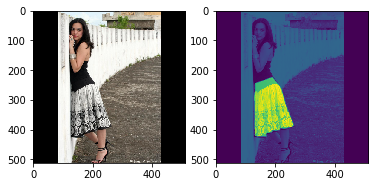

In [36]:
batch_size = 1
train_gen  = ImgMask_sequencer(  fash_val, 
                                 batch_size=batch_size,
                                 name="Train Generator",
                                 input_shape=input_shape[0:2],
                                 output_shape=output_shape[0:2])

test_image = train_gen.__getitem__(1)

fig, ax = plt.subplots(ncols=2)


ax[0].imshow(test_image[0][0])

mresized = resize(test_image[1][0], input_shape[0:2])
ax[1].imshow(test_image[0][0][:,:,1]+mresized[:,:,9]*2);

## Setup RESNET Models

## Unet Architecture
![title](../../unet/Unet_architecture.png)

In [37]:
input_shape

(512, 512, 3)

In [38]:
resnet = ResNet50(include_top=False, 
                 weights='imagenet', 
                 input_tensor=Input(shape=input_shape), 
                 input_shape=input_shape, 
                 pooling=None, 
                 classes=1000)

In [39]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [40]:

def UNet_Resnet(input_shape:tuple=(512,512,3), resnet=ResNet50, n_classes=n_classes):
    
    resnet = resnet(include_top=False, 
                 weights='imagenet', 
                 input_tensor=Input(shape=input_shape), 
                 input_shape=input_shape, 
                 pooling=None, 
                 classes=1000)

    # add layers on top of the base model
    encoder = resnet.output # 16,16,2048
#     encoder = MaxPooling2D(pool_size=(2,2))(encoder)
    encoder = Conv2D(1024, (3,3), activation='relu', padding='same')(encoder)

    # Decoder Path
    dec4 = UpSampling2D((2,2))(encoder)
    dec4 = concatenate([dec4,resnet.get_layer('conv4_block6_out').output]) # each/ 32,32,1024
    dec4 = Conv2D(1024, (3,3), activation='relu', padding='same')(dec4)
    dec4 = Conv2D(1024, (3,3), activation='relu', padding='same')(dec4)

    dec3 = UpSampling2D((2,2))(dec4)
    dec3 = concatenate([dec3,resnet.get_layer('conv3_block4_out').output]) # each/ 64,64,512
    dec3 = Conv2D(512, (3,3), activation='relu', padding='same')(dec3)
    dec3 = Conv2D(512, (3,3), activation='relu', padding='same')(dec3)

    dec2 = UpSampling2D((2,2))(dec3)
    dec2 = concatenate([dec2,resnet.get_layer('conv2_block3_out').output]) # each/ 128,128,256
    dec2 = Conv2D(256, (3,3), activation='relu', padding='same')(dec2)
    dec2 = Conv2D(256, (3,3), activation='relu', padding='same')(dec2)

    dec1 = UpSampling2D((2,2))(dec2)
    dec1 = concatenate([dec1,resnet.get_layer('conv1_conv').output]) # each/ 256,256,64
    dec1 = Conv2D(128, (3,3), activation='relu', padding='same')(dec1)
    dec1 = Conv2D(128, (3,3), activation='relu', padding='same')(dec1)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(dec1)
    print("input  shape: ", resnet.input.shape.dims[1:])
    print("output shape: ", outputs.shape.dims[1:])

    # set up model
    model = Model(inputs=resnet.input, outputs=outputs)
    
    return model, resnet.input.shape.dims[1:], outputs.shape.dims[1:], n_classes

### Train Model

In [41]:
def train_resnet(model,
                 train_data,
                 val_data,
                 epochs=10,
                 input_shape:tuple=(512,512,3), 
                 output_shape:tuple=(128,128,3),
                 batch_size:int=128,
                 logs_base_dir:str="./logs"
                 ):
    """
    Train model.  Resnet will take in a larger shape than the output by a factor of 2^2.
    """

    # Setup callbacks
    logdir=os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    callbacks = [
        EarlyStopping(patience=3, verbose=1),
#         ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
        ModelCheckpoint(os.path.join(logdir,'model-unet-resnet-fashion.h5'), verbose=1, save_best_only=True, save_weights_only=True),
        TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=batch_size, update_freq='batch')
    ]

    # Get generators for training and validation
    train_gen  = ImgMask_sequencer(  fash_train, 
                                     batch_size=batch_size,
                                     name="Train Generator",
                                     input_shape=input_shape[0:2],
                                     output_shape=output_shape[0:2])

    val_gen   = ImgMask_sequencer(   fash_val, 
                                     batch_size=batch_size,
                                     name="Val Generator",
                                     input_shape=input_shape[0:2],
                                     output_shape=output_shape[0:2])

    # optimizer = SGD(lr=.002,momentum=.9)
    optimizer = Adam()
    model.compile(optimizer=optimizer, 
                  loss="categorical_crossentropy", 
                  metrics=["accuracy"])

    results = model.fit_generator(  train_gen,  
                                    epochs=epochs,
                                    callbacks=callbacks, 
                                    validation_data=val_gen) #,
    #                                 use_multiprocessing=True, workers=4)

    return results

In [42]:
resnet_model, input_shape, output_shape, resnet_classes  = UNet_Resnet(input_shape=input_shape, 
                                                                       resnet=ResNet50, 
                                                                       n_classes=n_classes)

input  shape:  [Dimension(512), Dimension(512), Dimension(3)]
output shape:  [Dimension(256), Dimension(256), Dimension(47)]


In [43]:
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Set Trainable Layers

In [44]:
# set trainable layers - conv 5 and after
istrainable = False
for layer in resnet_model.layers:
    
    if layer.name=='conv5_block1_1_conv': #conv5_block1_1_conv
        istrainable = True
    
    layer.trainable = istrainable

# for l in resnet_model.layers:
#     print(l.name,l.trainable)

In [45]:
# # add tensorboard to notebook
%load_ext tensorboard

logs_base_dir = os.path.join(data_dir, "logs")
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10484), started 2:09:12 ago. (Use '!kill 10484' to kill it.)

In [49]:
input_shape = [s.value for s in input_shape]
output_shape = [s.value for s in output_shape]


In [51]:
input_shape, output_shape

([512, 512, 3], [256, 256, 47])

In [52]:
batch_size = 64
epochs = 1
train_resnet(resnet_model,
             fash_train,
             fash_val,
             epochs=epochs,
             input_shape=input_shape,
             output_shape=output_shape,
             batch_size=batch_size,
             logs_base_dir=logs_base_dir
             )

Creating Generator 'Train Generator':
	batch size :  64
	length     :  10975
	num batches:  172
	input shape :  [512, 512]
	output shape:  [256, 256]
	num classes:  47
Creating Generator 'Val Generator':
	batch size :  64
	length     :  2744
	num batches:  43
	input shape :  [512, 512]
	output shape:  [256, 256]
	num classes:  47
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  5/172 [..............................] - ETA: 27:06:11 - loss: 1.5173 - acc: 0.0317 

KeyboardInterrupt: 

Things to try:

- change batch size to 64 (in process)
- change lr=.01(from .001)
- start retaining from conv4 (in process)